DINOv2 Baseline - Plant Identification

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This cell initializes the environment for a deep learning project on herbarium species classification. It:

- Loads all required libraries for image processing, ML, and evaluation.

- Defines dataset paths for reproducibility and structured access.

- Prepares the hardware device (GPU/CPU) for training and inference.

In [ ]:
# --- Imports ---
import os
import torch
import timm
import torch.nn as nn
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import top_k_accuracy_score
import tarfile

# Define paths
ROOT = "/content/drive/MyDrive/COS30082 A2/AML_project_herbarium_dataset"
TRAIN_LIST = os.path.join(ROOT, "list/train.txt")
TEST_LIST = os.path.join(ROOT, "list/test.txt")
SPECIES_LIST = os.path.join(ROOT, "list/species_list.txt")
GROUNDTRUTH = os.path.join(ROOT, "list/groundtruth.txt")
CLASS_WITH = os.path.join(ROOT, "list/class_with_pairs.txt")
CLASS_WITHOUT = os.path.join(ROOT, "list/class_without_pairs.txt")

TRAIN_DIR = os.path.join(ROOT, "train")
TEST_DIR = os.path.join(ROOT, "test")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


This cell automates the setup of a pretrained model checkpoint by:

- Extracting the compressed archive into a working directory.

- Ensuring the model file (model_best.pth.tar) is located and accessible.

- Providing error handling if the expected file is missing.

This guarantees that subsequent training or inference steps can reliably load the correct pretrained weights.

In [ ]:
TAR_PATH = "/content/drive/MyDrive/COS30082 A2/dinov2_patch14_reg4_onlyclassifier_then_all-pytorch-default-v3.tar.gz"
EXTRACT_DIR = "/content/dinov2_model"

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    with tarfile.open(TAR_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_DIR)
    print(f"Extracted model files to: {EXTRACT_DIR}")
else:
    print(f"Model already extracted at: {EXTRACT_DIR}")

# Find model_best.pth.tar inside
MODEL_PATH = None
for root, dirs, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.endswith(".pth.tar"):
            MODEL_PATH = os.path.join(root, f)
            break

if MODEL_PATH is None:
    raise FileNotFoundError("model_best.pth.tar not found inside extracted folder.")

print("Found model file:", MODEL_PATH)

/tmp/ipython-input-860853034.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(EXTRACT_DIR)


Extracted model files to: /content/dinov2_model
Found model file: /content/dinov2_model/model_best.pth.tar


This cell loads and organizes dataset metadata for the herbarium classification project. It:

- Defines a helper function to read ID lists from text files.

- Loads training and testing sample IDs into train_list and test_list.

- Builds a species_map dictionary linking numeric IDs to species names.

- Reads ground truth labels and class relationship files (paired vs. unpaired classes).

- Prints summary statistics showing the number of training entries, test entries, species, and class groupings.

This setup ensures that the dataset structure and label mappings are correctly initialized before training or evaluation.

In [ ]:
def read_id_file(path):
    with open(path) as f:
        return [line.strip() for line in f if line.strip()]

train_list = read_id_file(TRAIN_LIST)
test_list = read_id_file(TEST_LIST)
species_map = {}
with open(SPECIES_LIST) as f:
    for line in f:
        parts = line.strip().replace(";", " ").split()
        if len(parts) >= 2:
            species_map[int(parts[0])] = " ".join(parts[1:])

groundtruth = [int(x.strip().split()[-1].replace(";", "")) for x in open(GROUNDTRUTH)]
classes_with_pairs = set(map(int, open(CLASS_WITH).read().replace(";", "").split()))
classes_without_pairs = set(map(int, open(CLASS_WITHOUT).read().replace(";", "").split()))

print(f"Loaded {len(train_list)} train entries, {len(test_list)} test entries.")
print(f"{len(species_map)} species, {len(classes_with_pairs)} paired, {len(classes_without_pairs)} unpaired.")


Loaded 4744 train entries, 207 test entries.
100 species, 60 paired, 40 unpaired.


This cell loads and prepares a fine‑tuned DINOv2 model for inference. It:

- Creates the Vision Transformer (ViT) architecture using timm.

- Loads the pretrained checkpoint from the extracted model file.

- Cleans the state dictionary to remove unnecessary prefixes before applying it.

- Replaces the classification head with an identity layer (so features can be used directly).

- Moves the model to the selected device (GPU/CPU) and sets it to evaluation mode.

- Confirms successful loading with a print statement.

This ensures the fine‑tuned DINOv2 model is correctly initialized and ready for feature extraction or downstream tasks.

In [ ]:
# --- Load Fine-Tuned DINOv2 Model ---
torch.serialization.add_safe_globals([argparse.Namespace])

model = timm.create_model("vit_base_patch14_reg4_dinov2.lvd142m", pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict, strict=False)
model.head = nn.Identity()
model = model.to(device)
model.eval()
print("Fine-tuned DINOv2 model loaded successfully.")

Fine-tuned DINOv2 model loaded successfully.


This cell defines the image preprocessing pipeline used before feeding data into the model. It:

- Resizes all input images to a fixed size of 518 × 518 pixels.

- Converts images into PyTorch tensors for model compatibility.

- Normalizes pixel values using the ImageNet standard mean and standard deviation, ensuring consistent input distribution.

This preprocessing step standardizes the dataset, making it suitable for feature extraction and classification with the fine‑tuned DINOv2 model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

This cell handles feature extraction for both training and testing datasets using the fine‑tuned DINOv2 model. It:

- Defines helper functions to load images and preprocess them with the transformation pipeline.

- Extracts feature vectors from training images while keeping their labels.

- Loads the ground truth mapping for test images to ensure correct label assignment.

- Extracts features from the test set using this ground truth, producing aligned feature–label pairs.

- Prints summary counts of loaded entries and extracted features.

Together, these steps prepare numerical feature representations of the dataset, enabling downstream machine learning tasks such as classification or evaluation.

In [ ]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

def extract_features_from_list(file_list, base_dir, has_labels=True):
    features, labels = [], []
    for line in tqdm(file_list, desc="Extracting features"):
        parts = line.replace(";", " ").split()
        if has_labels:
            if len(parts) < 2:
                continue
            rel_path, label = parts[0], int(parts[1])
        else:
            rel_path, label = parts[0], 0  # dummy label

        rel_path = rel_path.replace("train/", "")
        img_path = os.path.join(base_dir, rel_path)

        if not os.path.exists(img_path):
            print("Missing:", img_path)
            continue

        img = load_image(img_path)
        with torch.no_grad():
            feat = model(img).cpu().numpy().flatten()
        features.append(feat)
        labels.append(label)
    return np.array(features), np.array(labels)


print("Extracting training features...")
X_train, y_train = extract_features_from_list(train_list, TRAIN_DIR, has_labels=True)

# --- Load Groundtruth for test set (image path + class id) ---
groundtruth_path = "/content/drive/MyDrive/COS30082 A2/AML_project_herbarium_dataset/list/groundtruth.txt"

groundtruth_map = {}
with open(groundtruth_path) as f:
    for line in f:
        parts = line.strip().replace(";", " ").split()
        if len(parts) >= 2:
            img_name = os.path.basename(parts[0])  # e.g. "1745.jpg"
            label = int(parts[1])
            groundtruth_map[img_name] = label

print(f"Loaded {len(groundtruth_map)} groundtruth entries")

# --- Extract test features using correct labels ---
def extract_features_with_groundtruth(file_list, label_map, base_dir):
    features, y_true = [], []
    for line in tqdm(file_list, desc="Extracting test features"):
        img_name = os.path.basename(line.strip())
        img_path = os.path.join(base_dir, img_name)
        if not os.path.exists(img_path):
            print("Missing:", img_path)
            continue
        if img_name not in label_map:
            print("No label found for:", img_name)
            continue

        label = label_map[img_name]
        img = load_image(img_path)
        with torch.no_grad():
            feat = model(img).cpu().numpy().flatten()
        features.append(feat)
        y_true.append(label)
    return np.array(features), np.array(y_true)

X_test, y_test = extract_features_with_groundtruth(test_list, groundtruth_map, TEST_DIR)
print(f"Extracted {len(X_test)} test features with groundtruth labels")


Extracting training features...


Extracting features: 100%|██████████| 4744/4744 [28:08<00:00,  2.81it/s]


Loaded 207 groundtruth entries


Extracting test features: 100%|██████████| 207/207 [01:10<00:00,  2.95it/s]

Extracted 207 test features with groundtruth labels


This cell performs label diagnostics to check dataset consistency between training and testing sets. It:

- Prints the numeric range of labels present in both training and test sets.

- Reports the number of unique labels in each set.

- Identifies labels that appear in the test set but are unseen in training, which could cause evaluation issues.

- Displays the count of unseen labels and lists the first few for inspection.

This diagnostic step ensures awareness of potential label mismatches, helping to validate dataset integrity before training or evaluation.

In [ ]:
import numpy as np

print("Label diagnostics:")
print("Train label range:", min(y_train), "-", max(y_train))
print("Test label range:", min(y_test), "-", max(y_test))
print("Unique train labels:", len(np.unique(y_train)))
print("Unique test labels:", len(np.unique(y_test)))

# Which test labels are unseen in training?
unseen = sorted(set(y_test) - set(y_train))
print(f"\n Unseen labels in test set: {len(unseen)}")
print(unseen[:50])  # show first few


Label diagnostics:
Train label range: 12254 - 285398
Test label range: 12254 - 285398
Unique train labels: 100
Unique test labels: 100

 Unseen labels in test set: 0
[]


This cell trains and applies a Support Vector Machine (SVM) classifier on the extracted DINOv2 features. It:

- Standardizes the training and test feature vectors using StandardScaler for balanced input scaling.

- Initializes a linear‑kernel SVM with probability estimates enabled.

- Fits the classifier on the training features and labels.

- Generates predictions (y_pred) and class probabilities (y_prob) for the test set.

- Prints confirmation messages for successful training and prediction.

This step establishes the final classification model, turning extracted image features into species label predictions.

In [ ]:
print("Training SVM classifier...")
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

svm = SVC(kernel="linear", probability=True)
svm.fit(X_train_std, y_train)
print("SVM training complete.")

y_pred = svm.predict(X_test_std)
y_prob = svm.predict_proba(X_test_std)
print("Predictions generated successfully.")


Training SVM classifier...
SVM training complete.
Predictions generated successfully.


This cell evaluates the trained SVM classifier on the test dataset. It:

- Filters test labels to include only classes that the SVM was trained on, preventing mismatches.

- Reports the number of total test samples, valid samples after filtering, and the number of trained classes.

- Handles edge cases where too few valid samples remain, warning about possible label mismatches.

- Computes Top‑1 and Top‑5 accuracy scores to measure classification performance.

This ensures that evaluation results are valid and provides clear performance metrics for the classifier.

In [ ]:
print("Evaluating classifier...")

# --- Ensure y_test only has classes known to the SVM ---
mask = np.isin(y_test, svm.classes_)
y_test_filtered = y_test[mask]
y_prob_filtered = y_prob[mask]
y_pred_filtered = y_pred[mask]

print(f"Total test samples: {len(y_test)}")
print(f"Samples after filtering to known SVM classes: {len(y_test_filtered)}")
print(f"Number of classes trained in SVM: {len(svm.classes_)}")

# --- Handle edge case ---
if len(y_test_filtered) < 2:
    print("Not enough valid test samples after filtering. Check class label mismatch.")
    print("Possible causes:")
    print("- y_test has labels that do not appear in y_train.")
    print("- SVM only trained on a small subset of classes.")
else:
    # --- Calculate Top-K Accuracies safely ---
    top1 = top_k_accuracy_score(y_test_filtered, y_prob_filtered, k=1, labels=svm.classes_)
    top5 = top_k_accuracy_score(y_test_filtered, y_prob_filtered, k=5, labels=svm.classes_)

    print(f"Top-1 Accuracy: {top1*100:.2f}%")
    print(f"Top-5 Accuracy: {top5*100:.2f}%")

Evaluating classifier...
Total test samples: 207
Samples after filtering to known SVM classes: 207
Number of classes trained in SVM: 100
Top-1 Accuracy: 72.95%
Top-5 Accuracy: 75.36%


This cell evaluates classifier performance separately on paired vs. unpaired classes. It:

- Splits test samples into two groups based on whether their labels belong to paired or unpaired class sets.

- Defines a helper function to safely compute Top‑k accuracy (handling empty subsets).

- Calculates Top‑1 and Top‑5 accuracies for both paired and unpaired groups.

- Prints the results, allowing comparison of model performance across these two subsets.

This analysis highlights whether the classifier performs differently on classes with defined pair relationships versus those without, providing deeper insight into dataset structure and model generalization.

In [ ]:
# --- Evaluate Paired vs Unpaired Classes ---

print("Evaluating Paired vs Unpaired Classes (Top-1 & Top-5)...")

# Split indices
paired_idx = [i for i, y in enumerate(y_test) if y in classes_with_pairs]
unpaired_idx = [i for i, y in enumerate(y_test) if y in classes_without_pairs]

# Helper function to compute top-k accuracy safely
def safe_topk(y_true, y_prob, k):
    if len(y_true) == 0:
        return 0.0
    return top_k_accuracy_score(
        y_true, y_prob, k=k, labels=svm.classes_
    ) * 100

# Compute for paired
if paired_idx:
    y_true_paired = np.array(y_test)[paired_idx]
    y_prob_paired = y_prob[paired_idx]
    paired_top1 = safe_topk(y_true_paired, y_prob_paired, k=1)
    paired_top5 = safe_topk(y_true_paired, y_prob_paired, k=5)
else:
    paired_top1 = paired_top5 = 0.0

# Compute for unpaired
if unpaired_idx:
    y_true_unpaired = np.array(y_test)[unpaired_idx]
    y_prob_unpaired = y_prob[unpaired_idx]
    unpaired_top1 = safe_topk(y_true_unpaired, y_prob_unpaired, k=1)
    unpaired_top5 = safe_topk(y_true_unpaired, y_prob_unpaired, k=5)
else:
    unpaired_top1 = unpaired_top5 = 0.0

# Print results
print(f"Paired-class Top-1 Accuracy: {paired_top1:.2f}%")
print(f"Paired-class Top-5 Accuracy: {paired_top5:.2f}%")
print(f"Unpaired-class Top-1 Accuracy: {unpaired_top1:.2f}%")
print(f"Unpaired-class Top-5 Accuracy: {unpaired_top5:.2f}%")


Evaluating Paired vs Unpaired Classes (Top-1 & Top-5)...
Paired-class Top-1 Accuracy: 97.39%
Paired-class Top-5 Accuracy: 99.35%
Unpaired-class Top-1 Accuracy: 3.70%
Unpaired-class Top-5 Accuracy: 7.41%


This cell saves the trained SVM model and training data arrays for future use. It:

- Creates an output directory if it doesn’t already exist.

- Stores the trained SVM classifier as a .pkl file using joblib.

- Saves the training features (X_train) and labels (y_train) as .npy files with NumPy.

- Prints a confirmation message showing the save location.

This ensures that the model and its training data can be easily reloaded later without retraining, supporting reproducibility and efficient experimentation.

In [ ]:
import os, joblib
import numpy as np

out_dir = "/content/drive/MyDrive/AML_output"
os.makedirs(out_dir, exist_ok=True)   # create the folder if it doesn't exist

# now save your model and arrays
joblib.dump(svm, os.path.join(out_dir, "svm_model.pkl"))
np.save(os.path.join(out_dir, "X_train.npy"), X_train)
np.save(os.path.join(out_dir, "y_train.npy"), y_train)

print("Saved SVM model and training arrays into", out_dir)


Saved SVM model and training arrays into /content/drive/MyDrive/AML_output


This cell runs a prediction demo on random test images to visually showcase the classifier’s performance. It:

- Randomly selects a handful of test samples.

- Loads and displays each image using Matplotlib.

- Extracts features with the fine‑tuned DINOv2 model, standardizes them, and applies the trained SVM.

- Prints the true label alongside the Top‑5 predicted species with confidence scores.

- Tracks Top‑1 prediction accuracy across the sampled images.

- Displays the images in a grid and reports the demo accuracy.

This provides an intuitive, human‑readable validation of the model by combining visual inspection with prediction results, making it easier to assess how well the classifier performs on real test samples.

Running Prediction Demo on Random Test Images...
 1130.jpg
   True: Guatteria ouregou (Aubl.) Dunal
   Top-5 Predictions:
     1. Guatteria ouregou (Aubl.) Dunal (58.07%)
     2. Sapium glandulosum (L.) Morong (2.97%)
     3. Ocotea puberula (Rich.) Nees (1.68%)
     4. Tapirira guianensis Aubl. (1.60%)
     5. Ocotea longifolia Kunth (1.46%)
--------------------------------------------------
 281951.jpg
   True: Jatropha curcas L.
   Top-5 Predictions:
     1. Jatropha curcas L. (57.77%)
     2. Hura crepitans L. (2.72%)
     3. Ricinus communis L. (2.65%)
     4. Ceiba pentandra (L.) Gaertn. (2.35%)
     5. Piper peltatum L. (2.31%)
--------------------------------------------------
 21634.jpg
   True: Allamanda cathartica L.
   Top-5 Predictions:
     1. Allamanda cathartica L. (33.98%)
     2. Annona muricata L. (4.62%)
     3. Hibiscus rosa-sinensis L. (4.23%)
     4. Annona glabra L. (3.45%)
     5. Hura crepitans L. (3.21%)
--------------------------------------------------
 196

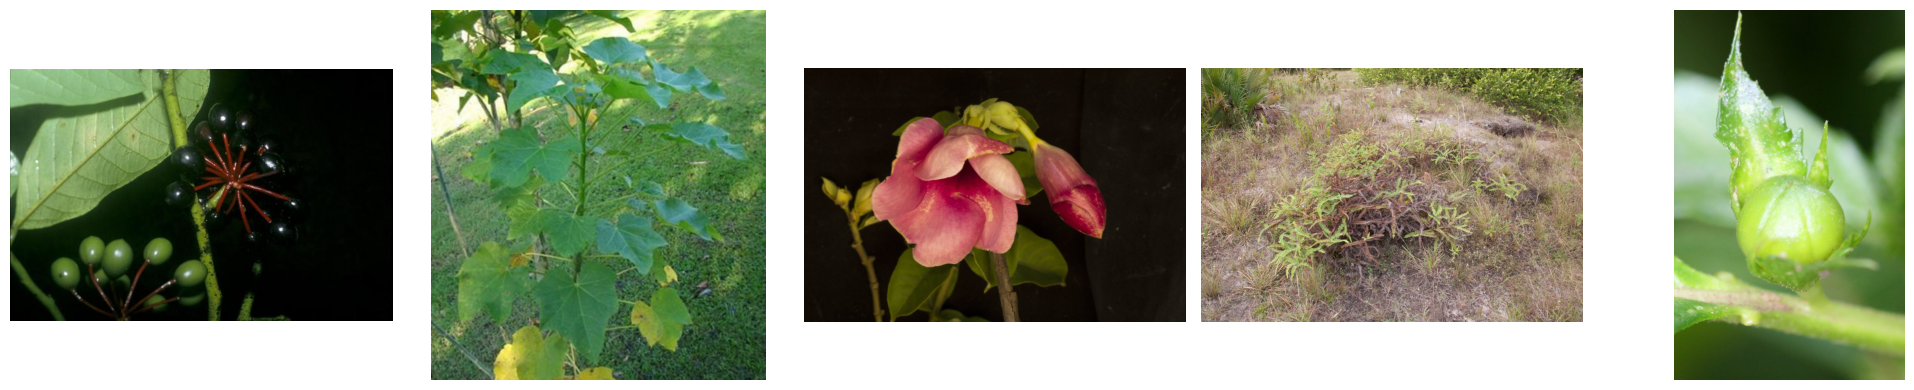


Demo Top-1 Accuracy on 5 Random Samples: 80.00%


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print("Running Prediction Demo on Random Test Images...")

# number of samples to show
num_samples = 5
if len(y_test) < num_samples:
    num_samples = len(y_test)

# choose random indices from the test set
sample_indices = random.sample(range(len(y_test)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))

correct = 0
for i, idx in enumerate(sample_indices):
    # parse image relative path from test_list (handles 'test/xxxxx.jpg' or 'xxxxx.jpg')
    img_relpath = test_list[idx].split()[0].replace(";", " ").strip()
    img_name = os.path.basename(img_relpath)
    img_path = os.path.join(TEST_DIR, img_name)

    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}")
        axes[i].axis("off")
        continue

    # display image
    img = Image.open(img_path).convert("RGB")
    axes[i].imshow(img)
    axes[i].axis("off")

    # extract features (no grad) and standardize
    with torch.no_grad():
        feat = model(transform(img).unsqueeze(0).to(device)).detach().cpu().numpy()

    feat_std = scaler.transform(feat)          # shape (1, D)
    probs = svm.predict_proba(feat_std)[0]     # shape (n_classes,)
    order = np.argsort(probs)[::-1]            # indices (positions) sorted desc

    # map positions -> actual class labels the SVM was trained with
    top5_class_labels = svm.classes_[order[:5]]   # real class ids (e.g., 12254, ...)
    top5_scores = probs[order[:5]]

    # Top-1 predicted class label & human name
    top1_label = int(top5_class_labels[0])
    true_label = int(y_test[idx])

    top1_name = species_map.get(top1_label, str(top1_label))
    true_name = species_map.get(true_label, str(true_label))

    # print results
    print(f" {img_name}")
    print(f"   True: {true_name}")
    print("   Top-5 Predictions:")
    for rank, (lbl, score) in enumerate(zip(top5_class_labels, top5_scores), 1):
        lbl = int(lbl)
        print(f"     {rank}. {species_map.get(lbl, lbl)} ({score*100:.2f}%)")
    print("-" * 50)

    # demo accuracy counting (top-1)
    if top1_label == true_label:
        correct += 1

plt.tight_layout()
plt.show()

demo_acc = correct / num_samples * 100 if num_samples > 0 else 0.0
print(f"\nDemo Top-1 Accuracy on {num_samples} Random Samples: {demo_acc:.2f}%")


This cell saves the trained models and supporting metadata for future reuse. It:

- Stores the PyTorch backbone in two formats:

  - state_dict (weights only) for lightweight reloading.

  - Full model object for complete restoration.

- Bundles the trained SVM classifier, its scaler, class labels, and species mapping into a single .pkl file using joblib.

- Prints confirmation messages showing where each artifact was saved.

This ensures both the deep learning backbone and the SVM classifier can be easily reloaded later, supporting reproducibility and deployment without retraining.

In [ ]:
import torch
import joblib

# --- Save PyTorch backbone (state_dict + full model) ---
MODEL_SAVE_PATH = "/content/drive/MyDrive/COS30082/dinov2_backbone.pth"
MODEL_FULL_PATH = "/content/drive/MyDrive/COS30082/dinov2_backbone_full.pth"

torch.save(model.state_dict(), MODEL_SAVE_PATH)
torch.save(model, MODEL_FULL_PATH)

print(f"Backbone state_dict saved to {MODEL_SAVE_PATH}")
print(f"Full model object saved to {MODEL_FULL_PATH}")

# --- Save SVM + scaler + metadata in one bundle ---
SVM_SAVE_PATH = "/content/drive/MyDrive/COS30082/svm_bundle.pkl"

joblib.dump({
    "svm": svm,
    "scaler": scaler,
    "classes": svm.classes_,
    "species_map": species_map
}, SVM_SAVE_PATH)

print(f"SVM bundle saved to {SVM_SAVE_PATH}")


Backbone state_dict saved to /content/drive/MyDrive/AML_output/dinov2_backbone.pth
Full model object saved to /content/drive/MyDrive/AML_output/dinov2_backbone_full.pth
SVM bundle saved to /content/drive/MyDrive/AML_output/svm_bundle.pkl


This cell reloads the saved models and metadata for continued use without retraining. It:

- Reconstructs the DINOv2 backbone using timm, replaces its classification head with an identity layer, and loads the previously saved weights (state_dict).

- Moves the backbone to the correct device (GPU/CPU) and sets it to evaluation mode.

- Loads the bundled SVM classifier, scaler, class labels, and species mapping from the saved .pkl file.

This ensures that both the deep learning backbone and the SVM classifier are fully restored, enabling seamless inference or further evaluation.

In [ ]:
# Reload backbone
model = timm.create_model("vit_base_patch14_reg4_dinov2.lvd142m", pretrained=False)
model.head = nn.Identity()
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model = model.to(device).eval()

# Reload SVM bundle
bundle = joblib.load(SVM_SAVE_PATH)
svm = bundle["svm"]
scaler = bundle["scaler"]
classes = bundle["classes"]
species_map = bundle["species_map"]
